## Optimal 3D Printing Parameters Prediction

### 1. Problem statement
- Develop a predictive neural network model that can optimize 3D printing parameters (such as nozzle temperature, print speed, and layer height) to achieve desired outcomes in print quality and material properties (such as surface finish quality and tensile strength). The model should be trained on a dataset of printing parameters and corresponding outcomes, validated on separate data, and capable of suggesting optimal printing conditions to enhance the efficiency and quality of the 3D printing process.

### 2. Data Collection
- Dataset was acquired from [kaggle](https://www.kaggle.com/datasets/afumetto/3dprinter).

#### 2.1 Import Data and Required Packages

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from features_selection import *
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from ipywidgets import interact, widgets
from IPython.display import display, Markdown
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

##### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/data.csv')

##### Show Top 5 Records

In [3]:
df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


##### Shape of the dataset

In [4]:
df.shape

(50, 12)

#### 2.2 Dataset information

The aim of the study is to determine how much of the adjustment parameters in 3d printers affect the print quality, accuracy and strenght. Where there are nine setting parameters and three measured output parameters.


**Setting Parameters:**
- Layer Height (mm)
- Wall Thickness (mm)
- Infill Density (%)
- Infill Pattern ()
- Nozzle Temperature (Cº)
- Bed Temperature (Cº)
- Print Speed (mm/s)
- Material ()
- Fan Speed (%)

**Output Parameters:**
- Roughness (µm)
- Tensile (ultimate) Strength (MPa)
- Elongation (%)

### 3. Data Checks to perform

- Check Missing values
- Check Duplicates
- Check data type
- Check the number of unique values of each column
- Check statistics of data set
- Check various categories present in the different categorical column

#### 3.1 Check Missing values

In [5]:
df.isna().sum()

layer_height          0
wall_thickness        0
infill_density        0
infill_pattern        0
nozzle_temperature    0
bed_temperature       0
print_speed           0
material              0
fan_speed             0
roughness             0
tensile_strength      0
elongation            0
dtype: int64

``There are no null values in the dataset``

#### 3.2 Check Duplicates

In [6]:
print(df.duplicated().sum())

0


``There are no duplicates values in the dataset``

#### 3.3 Check data types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tensile_strength    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


#### 3.4 Checking the number of unique values of each column

In [8]:
df.nunique()

layer_height           5
wall_thickness        10
infill_density         9
infill_pattern         2
nozzle_temperature     9
bed_temperature        5
print_speed            3
material               2
fan_speed              5
roughness             44
tensile_strength      26
elongation            27
dtype: int64

#### 3.5 Check statistics of data set

In [9]:
df.describe()

,layer_height,wall_thickness,infill_density,nozzle_temperature,bed_temperature,print_speed,fan_speed,roughness,tensile_strength,elongation
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.0000,50.000000,50.000000,50.000000,50.000000
mean,0.106000,5.220000,53.40000,221.500000,70.000000,64.0000,50.000000,170.580000,20.080000,1.672000
std,0.064397,2.922747,25.36348,14.820353,7.142857,29.6923,35.714286,99.034129,8.925634,0.788188
min,0.020000,1.000000,10.00000,200.000000,60.000000,40.0000,0.000000,21.000000,4.000000,0.400000
25%,0.060000,3.000000,40.00000,210.000000,65.000000,40.0000,25.000000,92.000000,12.000000,1.100000
50%,0.100000,5.000000,50.00000,220.000000,70.000000,60.0000,50.000000,165.500000,19.000000,1.550000
75%,0.150000,7.000000,80.00000,230.000000,75.000000,60.0000,75.000000,239.250000,27.000000,2.175000
max,0.200000,10.000000,90.00000,250.000000,80.000000,120.0000,100.000000,368.000000,37.000000,3.300000


#### 3.6 Check various categories present in the different categorical column

In [10]:
df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


In [11]:
print(f"infill_pattern : {df['infill_pattern'].unique()}")
print(f"material : {df['material'].unique()}")

infill_pattern : ['grid' 'honeycomb']
material : ['abs' 'pla']


In [12]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 10 numerical features : ['layer_height', 'wall_thickness', 'infill_density', 'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed', 'roughness', 'tensile_strength', 'elongation']

We have 2 categorical features : ['infill_pattern', 'material']


### 4. Exploring Data ( Visualization )

#### 4.1 Visualize Output Parameters Distribution
- Histogram
- Kernel Distribution Function (KDE)

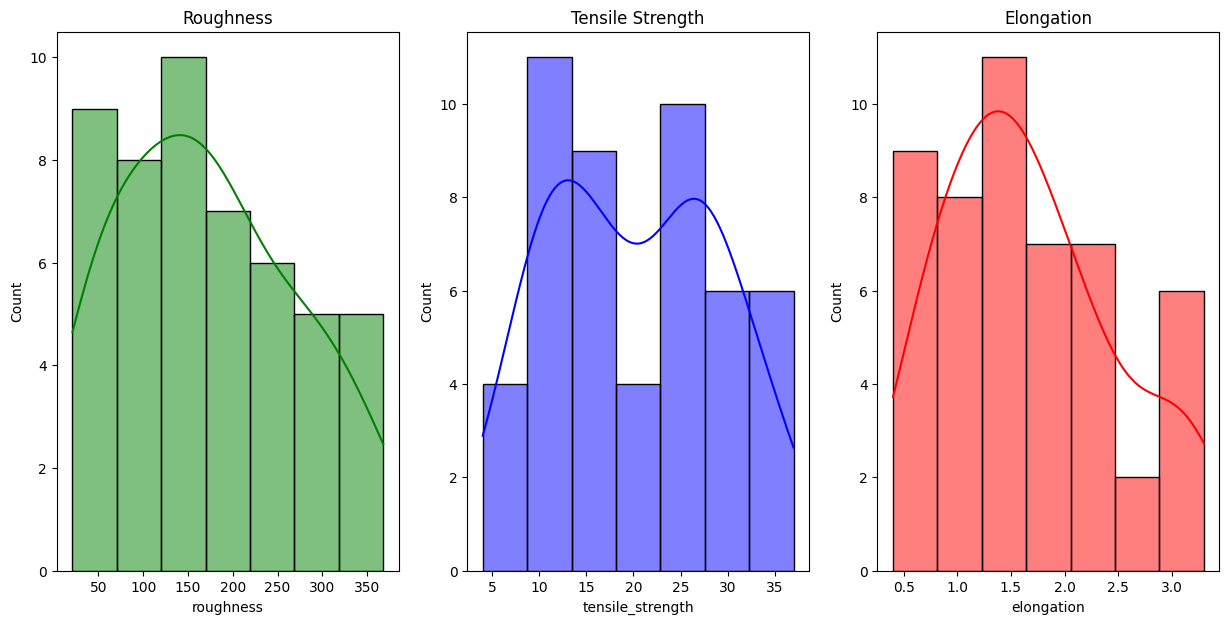

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
plt.subplot(131)
plt.title('Roughness')
sns.histplot(data=df,x='roughness',kde=True,color='g')
plt.subplot(132)
plt.title('Tensile Strength')
sns.histplot(data=df,x='tensile_strength',kde=True,color='b')
plt.subplot(133)
plt.title('Elongation')
sns.histplot(data=df,x='elongation',kde=True,color='r')
plt.show()

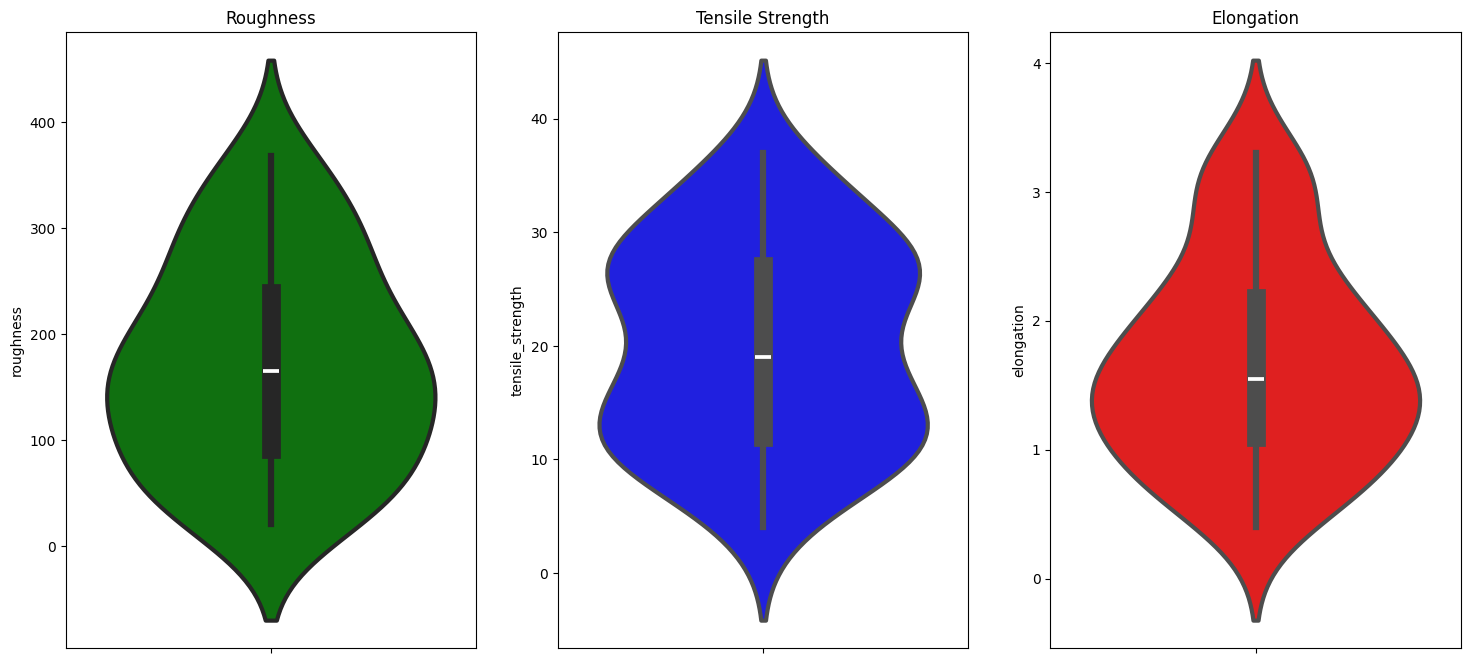

In [14]:
plt.figure(figsize=(18,8))
plt.subplot(131)
plt.title('Roughness')
sns.violinplot(y='roughness',data=df,color='green',linewidth=3)
plt.subplot(132)
plt.title('Tensile Strength')
sns.violinplot(y='tensile_strength',data=df,color='blue',linewidth=3)
plt.subplot(133)
plt.title('Elongation')
sns.violinplot(y='elongation',data=df,color='red',linewidth=3)
plt.show()

#### 4.3.2 Visualize Setting Parameters Distribution

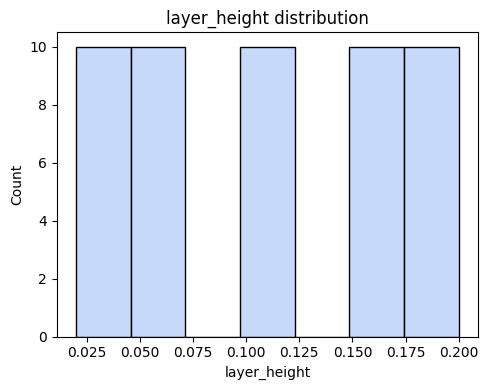

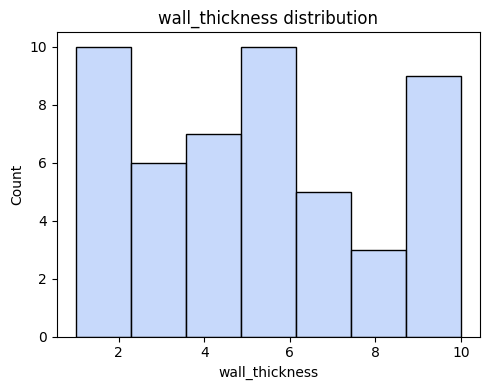

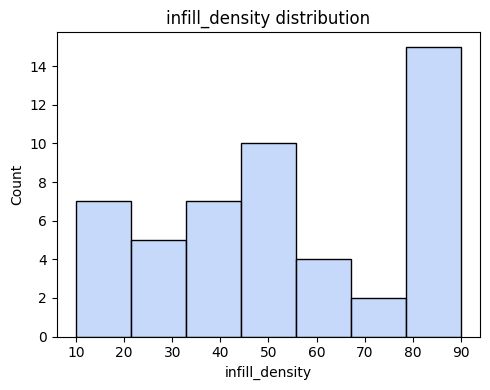

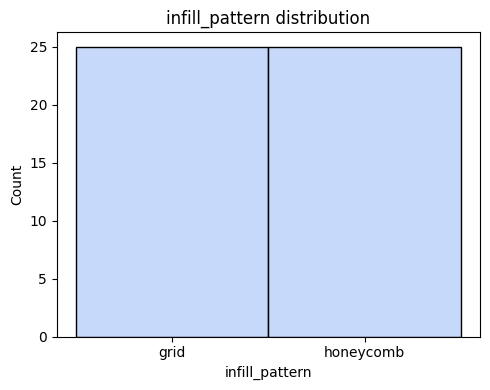

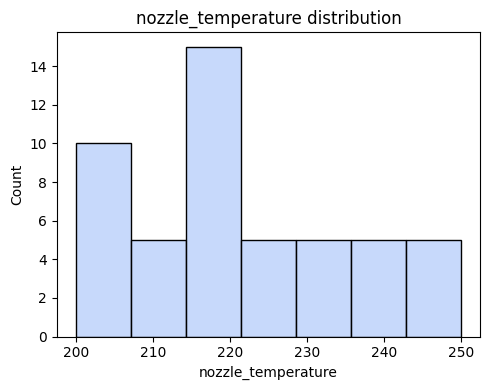

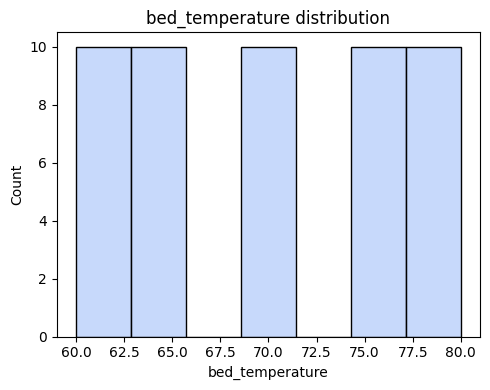

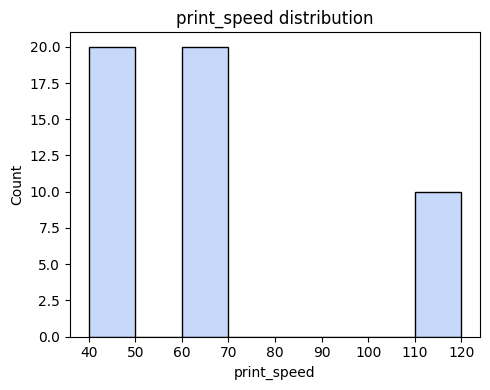

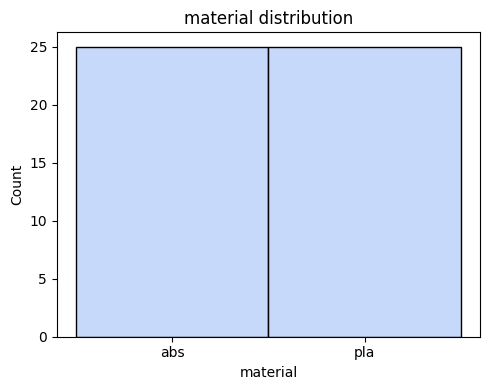

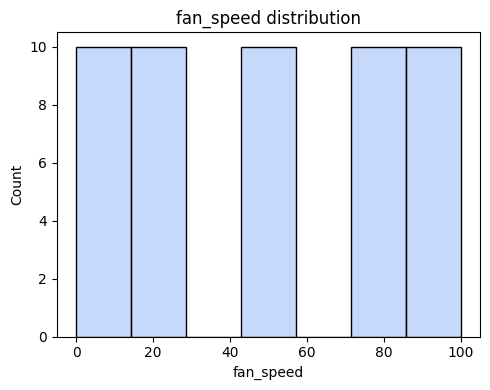

In [15]:
palette = sns.color_palette("coolwarm", 10)
color = palette[3]
for feature in df.columns[:-3]:
    plt.figure(figsize = (5,4))
    sns.histplot(df[feature],color = color)
    plt.title(f"{feature} distribution")
    plt.tight_layout()
    plt.show()

#### 4.3.4 CHECKING OUTLIERS

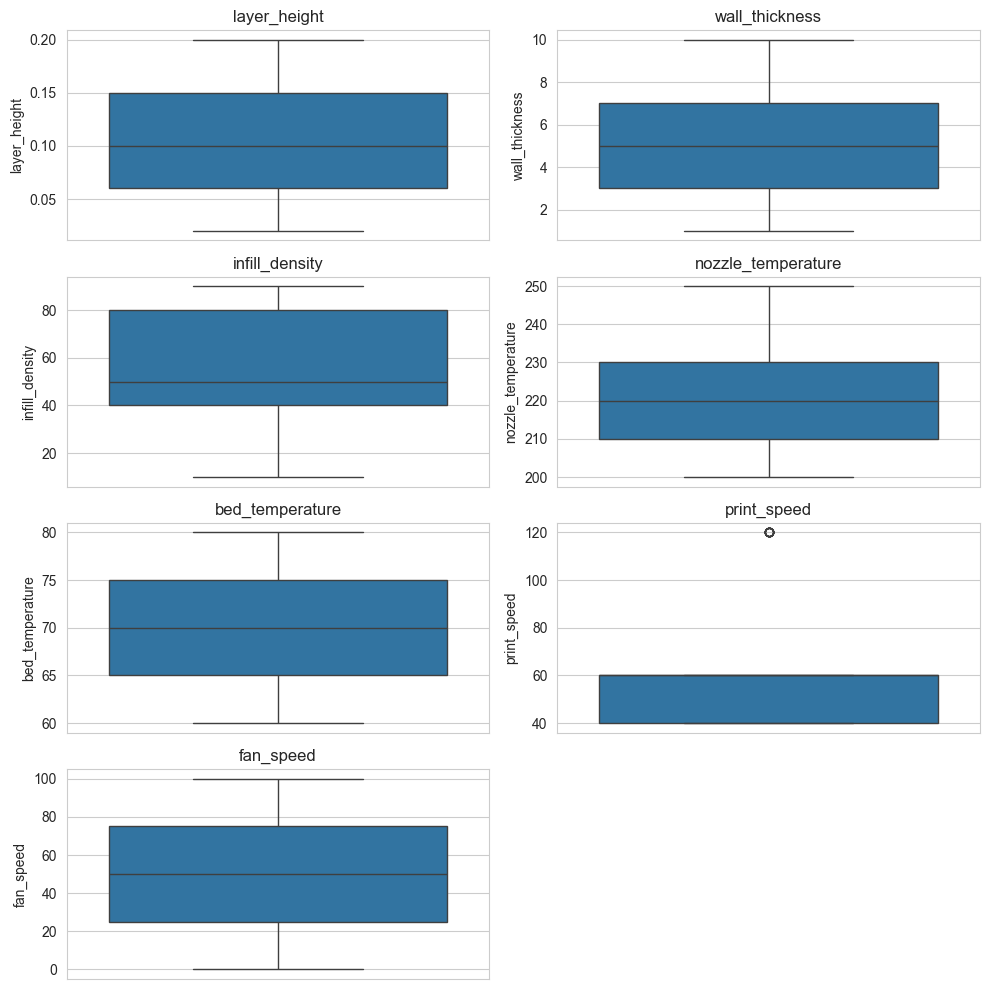

In [16]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
axes = axes.flatten()
categorical_columns = ['infill_pattern', 'material']
features = [col for col in df.columns[:-3] if col not in categorical_columns]
    
for i, feature in enumerate(features):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

``There is no outlier existing in the dataset``

### 5. Splitting Data to Features and Target (for further preprocessing)

In [17]:
X = df.drop(['roughness','tensile_strength','elongation'],axis=1)

In [18]:
y = df[['roughness','tensile_strength','elongation']]

In [19]:
X.shape

(50, 9)

In [20]:
y.shape

(50, 3)

### 7. Label_Encoding and Normalization

In [21]:
X.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed
0,0.02,8,90,grid,220,60,40,abs,0
1,0.02,7,90,honeycomb,225,65,40,abs,25
2,0.02,1,80,grid,230,70,40,abs,50
3,0.02,4,70,honeycomb,240,75,40,abs,75
4,0.02,6,90,grid,250,80,40,abs,100


In [22]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

numeric_transformer = StandardScaler()
oh_transformer = OrdinalEncoder()

preprocessor = ColumnTransformer(
    [
        ("LabelEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [23]:
P = preprocessor.fit_transform(X)

In [24]:
P.shape

(50, 9)

In [25]:
X = pd.DataFrame(data=P,columns = X.columns)

In [26]:
X.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed
0,0.0,0.0,-1.34903,0.960817,1.457670,-0.102240,-1.414214,-0.816497,-1.414214
1,1.0,0.0,-1.34903,0.615199,1.457670,0.238559,-0.707107,-0.816497,-0.707107
2,0.0,0.0,-1.34903,-1.458506,1.059399,0.579358,0.000000,-0.816497,0.000000
3,1.0,0.0,-1.34903,-0.421653,0.661129,1.260957,0.707107,-0.816497,0.707107
4,0.0,0.0,-1.34903,0.269582,1.457670,1.942555,1.414214,-0.816497,1.414214


In [27]:
# saving preprocessor model
with open('preprocessor.p', 'wb') as file:
    pickle.dump(preprocessor, file)

### 8. Features Selection

- Now, we can do some features selection on numeric features based on constant feature check, feature with high correlation with each other check, feature with low correlation with output check.

In [28]:
fs = Features_Selection(X,y,figsize=(15,15))

#### 8.1 Features Correlational Matrix

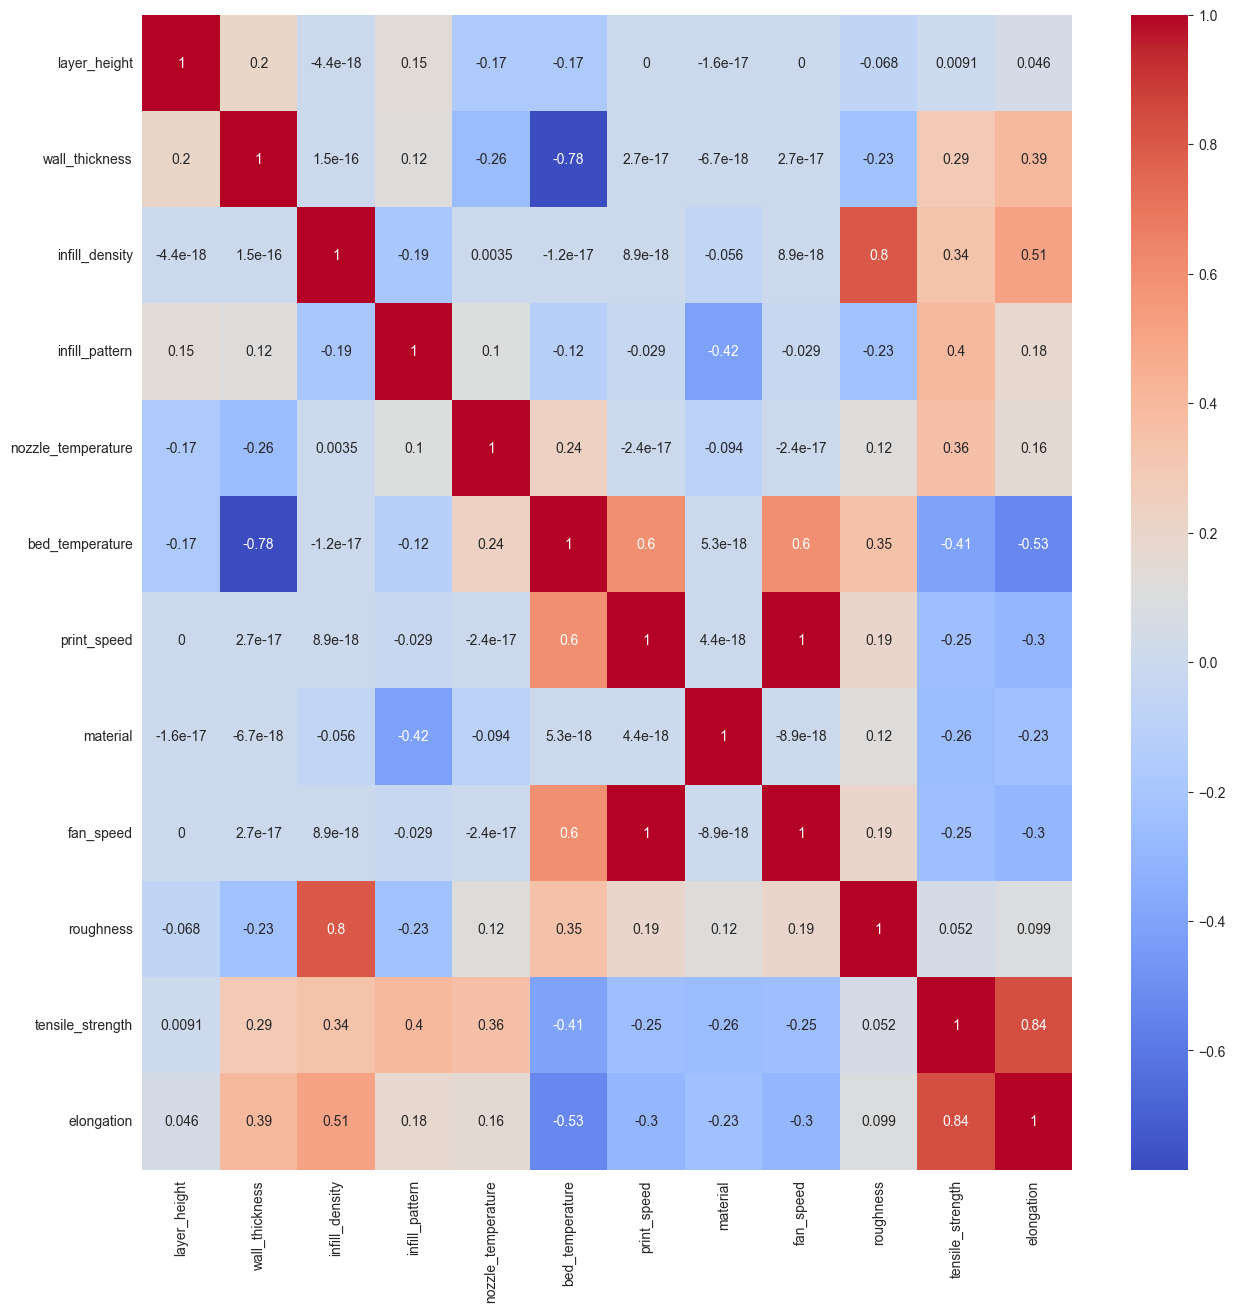

In [29]:
fs.corr_matrix_visual()
plt.show()

#### 8.2 Constant Features Selection

In [30]:
fs.const_features_selection(0.05)

Total Variable Features = 9
Total Constant Features = 0

All features have variance of more than 0.05.


#### 8.3 Filtering Features having strong Correlation with each other

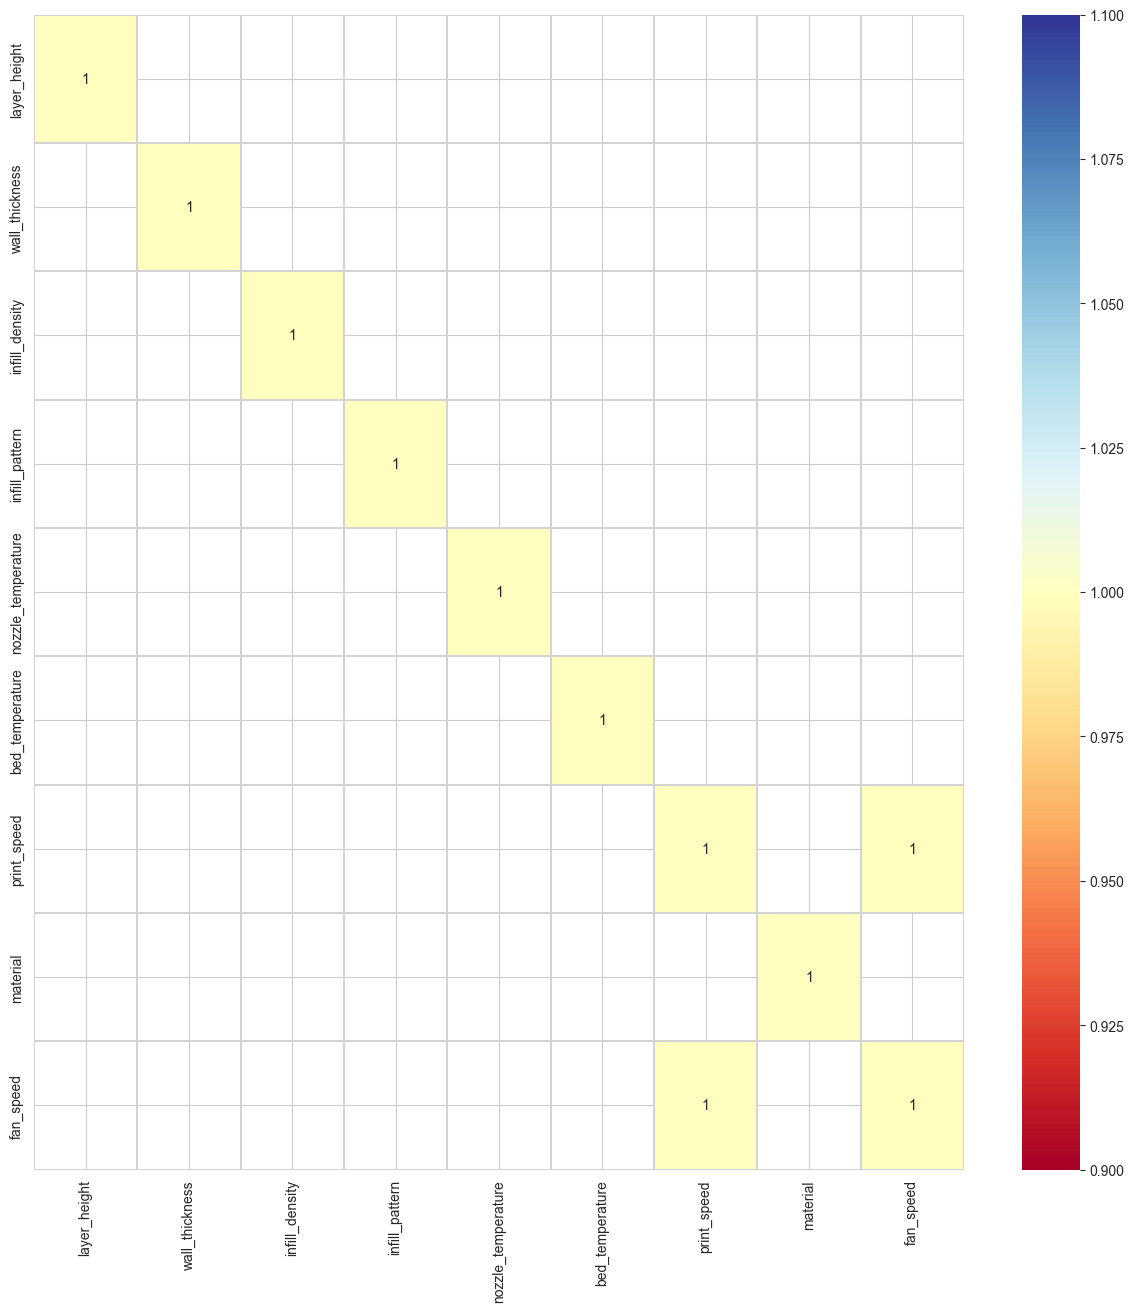

In [31]:
fs.features_corr_visual_filter(0.97)

In [32]:
fs.features_corr_filter(0.97)

{'fan_speed'}
Do you want to drop the features with correlation above threshold 0.97 ? (y/n) n
Features Not Dropped!


``In the given dataset, since both "print_speed" and "fan_speed" are varying in a structured manner, it results in a strong correlation. Also that "fan_speed" is not strictly a function of "print_speed" but varies within the range of "print_speed".So we didn't drop it.``

#### 8.4 Filtering Features having less Correlation with Output

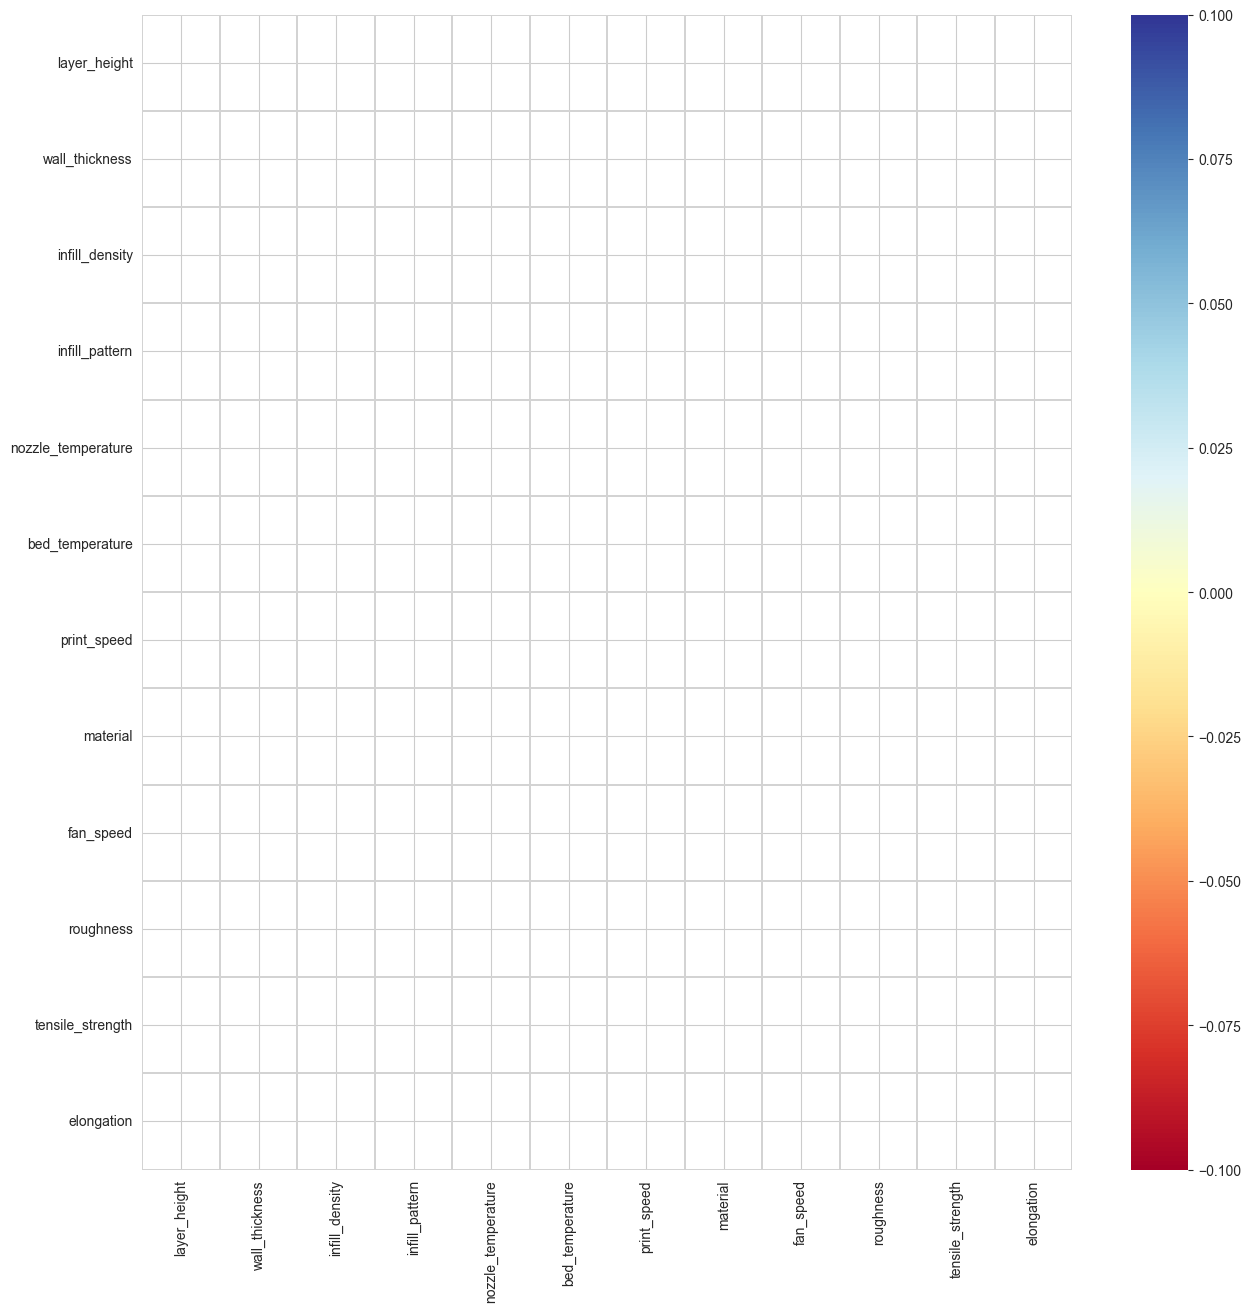

In [33]:
fs.features_corr_with_output_visual_filter(0.03)

In [35]:
fs.features_corr_with_output_filter(0.03)

All features have correlation of more than 0.03 with output.


### 9. Saving Preprocessed Data

In [36]:
preprocessed = pd.concat([X,y],axis =1)

In [37]:
preprocessed.shape

(50, 12)

In [38]:
preprocessed.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.0,0.0,-1.34903,0.960817,1.457670,-0.102240,-1.414214,-0.816497,-1.414214,25,18,1.2
1,1.0,0.0,-1.34903,0.615199,1.457670,0.238559,-0.707107,-0.816497,-0.707107,32,16,1.4
2,0.0,0.0,-1.34903,-1.458506,1.059399,0.579358,0.000000,-0.816497,0.000000,40,8,0.8
3,1.0,0.0,-1.34903,-0.421653,0.661129,1.260957,0.707107,-0.816497,0.707107,68,10,0.5
4,0.0,0.0,-1.34903,0.269582,1.457670,1.942555,1.414214,-0.816497,1.414214,92,5,0.7


In [39]:
preprocessed.to_csv('preprocessed.csv',index = False)